In [1]:
import os
import pickle
from functools import partial
from typing import Union

import argparse
import numpy as np
import pyabc
#from pyabc.sampler import RedisEvalParallelSampler
import scipy.stats as stats
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics
from tqdm import tqdm

from summary_stats import reduced_coordinates_to_sumstat, reduce_to_coordinates, compute_mean_summary_stats
from plotting_routines import plot_compare_summary_stats, plot_trajectory

# get the job array id and number of processors
job_array_id = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_procs = int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
print(job_array_id)
on_cluster = False
population_size = 1000

if on_cluster:
    parser = argparse.ArgumentParser(description='Parse necessary arguments')
    parser.add_argument('-pt', '--port', type=str, default="50004",
                        help='Which port should be use?')
    parser.add_argument('-ip', '--ip', type=str,
                        help='Dynamically passed - BW: Login Node 3')
    args = parser.parse_args()

0


In [2]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
}

model_path = gp + "/cell_movement_v24.xml"  # time step is 30sec, move.dir completely normalized, init move.dir rand in all directions
# defining the summary statistics function
max_sequence_length = 120
min_sequence_length = 0
only_longest_traj_per_cell = True  # mainly to keep the data batchable
cells_in_population = 50


def make_sumstat_dict(data: Union[dict, np.ndarray]) -> dict:
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]
    data = data[0]  # only one sample
    # compute the summary statistics
    summary_stats_dict = reduced_coordinates_to_sumstat(data)
    (ad_mean, _, msd_mean, _, ta_mean, _, vel_mean, _, wt_mean, _) = compute_mean_summary_stats([summary_stats_dict], remove_nan=False)
    cleaned_dict = {
        'ad': np.array(ad_mean).flatten(),
        'msd': np.array(msd_mean).flatten(),
        'ta': np.array(ta_mean).flatten(),
        'vel': np.array(vel_mean).flatten(),
        'wt': np.array(wt_mean).flatten()
    }
    return cleaned_dict


def prepare_sumstats(output_morpheus_model) -> dict:
    sim_coordinates = reduce_to_coordinates(output_morpheus_model, 
                          minimal_length=min_sequence_length, 
                          maximal_length=max_sequence_length,
                          only_longest_traj_per_cell=only_longest_traj_per_cell
                          )
    
    # we now do exactly the same as in the BayesFlow workflow, but here we get only one sample at a time
    data_transformed = np.ones((1, cells_in_population, max_sequence_length, 2)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    n_cells_not_visible = 0
    if len(sim_coordinates) != 0:
        # some cells were visible in the simulation
        for c_id, cell_sim in enumerate(sim_coordinates):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_transformed[0, c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_transformed[0, c_id, -len(cell_sim['y']):, 1] = cell_sim['y']
    
    return {'sim': data_transformed}


sumstat = SummaryStatistics(sum_stat_calculator=prepare_sumstats)                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis
    'move.strength': 10.,  # strength of directed motion
    'move.duration.mean': 0.1,  # mean of exponential distribution (1/seconds)
    'cell_nodes_real': 50.,  # volume of the cell
}


obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.mean': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
limits_log = {key: (np.log10(val[0]), np.log10(val[1])) for key, val in limits.items()}


prior = pyabc.Distribution(**{key: pyabc.RV("uniform", loc=lb, scale=ub-lb)
                              for key, (lb, ub) in limits_log.items()})
param_names = list(obs_pars.keys())
log_param_names = [f'log_{p}' for p in param_names]
print(obs_pars)

{'gradient_strength': 100.0, 'move.strength': 10.0, 'move.duration.mean': 0.1, 'cell_nodes_real': 50.0}


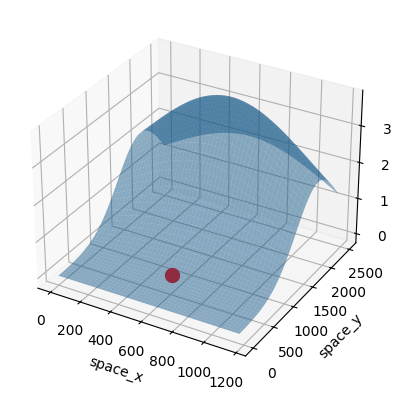

(586.5, 572.5190839694657, 1.801794707907847e-07, 3.68292430295295e-06)

In [3]:
import numpy as np
sigma0 = 550
space_x0 = 1173/2
space_y0 = 1500/1.31/2
x0, y0 = 1173/2, (1500+1500/2+270)/1.31
u1 = lambda space_x, space_y: 7/(2*np.pi*(sigma0**2)) *np.exp(-1/2*(((space_x)-(x0))**2+ ((space_y)-(y0))**2)/(sigma0**2))

# plot the function
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0, 1173 , 100)
y = np.linspace(0, 2500 , 100)
X, Y = np.meshgrid(x, y)
Z = u1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.5)
# plot start points
ax.scatter(space_x0, space_y0, u1(space_x0, space_y0), color='r', s=100)

ax.set_xlabel('space_x')
ax.set_ylabel('space_y')
plt.show()

space_x0, space_y0, u1(space_x0, space_y0), u1(x0, y0)

In [4]:
# simulate test data
test_params = np.array(list(obs_pars_log.values()))
if not os.path.exists(os.path.join(gp, 'test_sim.npy')):
    raise FileNotFoundError('Test data not found')
else:
    test_sim = np.load(os.path.join(gp, 'test_sim.npy'))

In [5]:
def obj_func_wass(sim: dict, obs: dict):
    total = 0
    for key in sim:
        x, y = np.array(sim[key]), np.array(obs[key])
        if x.size == 0:
            return np.inf
        total += stats.wasserstein_distance(x, y)
    return total

In [6]:
#redis_sampler = RedisEvalParallelSampler(host=args.ip, port=args.port,
#                                         adapt_look_ahead_proposal=False,
#                                         look_ahead=False)

abc = pyabc.ABCSMC(model, prior,
                   distance_function=obj_func_wass,
                   summary_statistics=make_sumstat_dict,
                   population_size=population_size,
                   sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                   #sampler=redis_sampler
                   )

db_path = os.path.join(gp, "abc_results/synthetic_test_old_sumstats.db")

if not os.path.exists(db_path):
    history = abc.new("sqlite:///" + db_path, make_sumstat_dict(test_sim))

    # start the abc fitting
    abc.run(min_acceptance_rate=1e-2, max_nr_populations=30)
    print('Done!')
else:
    history = abc.load("sqlite:///" + db_path)

ABC.Sampler INFO: Parallelize sampling on 5 processes.


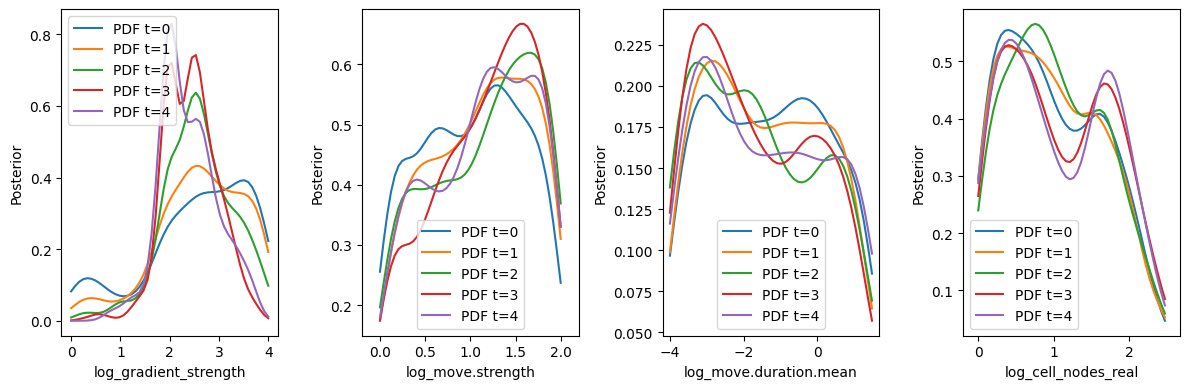

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


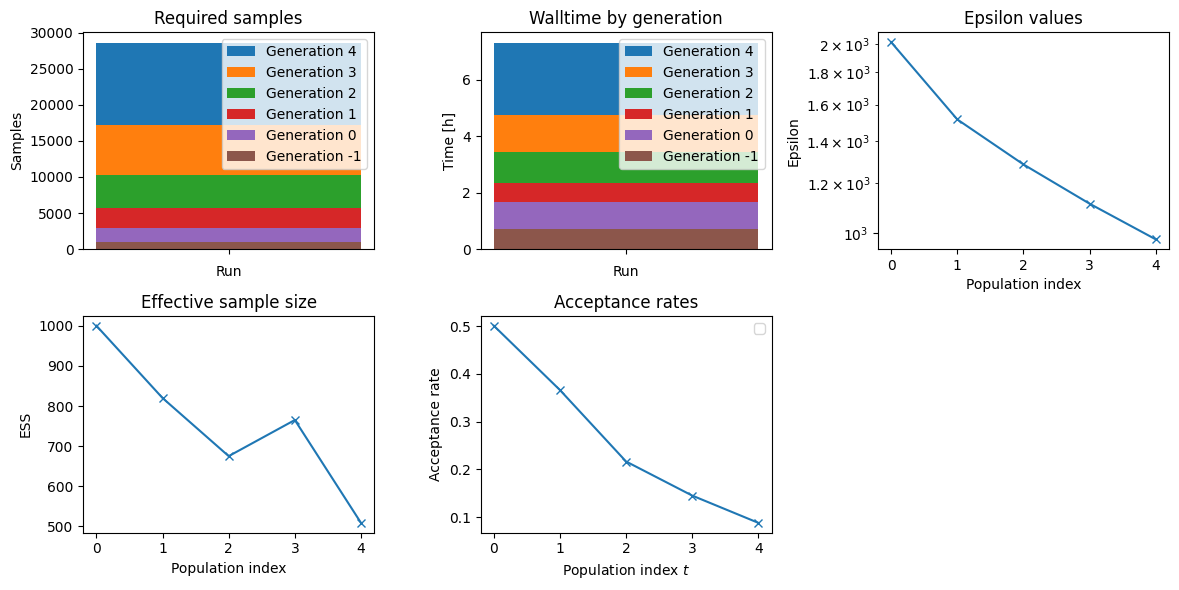

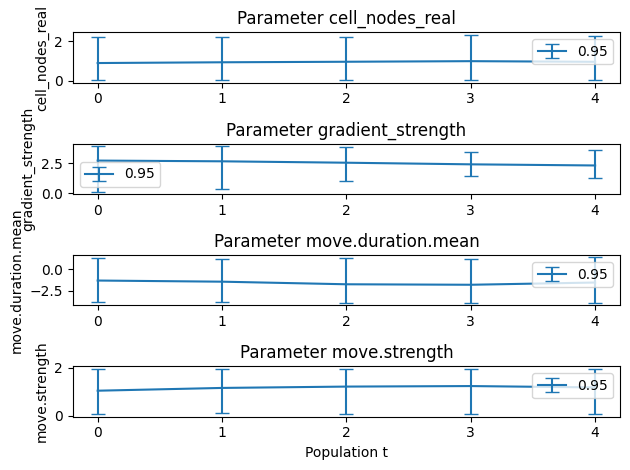

In [7]:
fig, ax = plt.subplots(1, len(param_names), tight_layout=True, figsize=(12, 4))
for i, param in enumerate(param_names):
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=limits_log[param][0],
            xmax=limits_log[param][1],
            x=param,
            xname=log_param_names[i],
            ax=ax[i],
            label=f"PDF t={t}",
        )
    ax[i].legend()
    ax[i].set_xlim((limits_log[param][0]-0.2, limits_log[param][1]+0.2))
plt.savefig(os.path.join(gp, 'abc_results/population_kdes.png'))
plt.show()

fig, arr_ax = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)
arr_ax = arr_ax.flatten()
pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0])
pyabc.visualization.plot_walltime(history, ax=arr_ax[1], unit='h')
pyabc.visualization.plot_epsilons(history, ax=arr_ax[2])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[3])
pyabc.visualization.plot_acceptance_rates_trajectory(history, ax=arr_ax[4])
# remove last axis
arr_ax[-1].axis('off')
plt.savefig(os.path.join(gp, 'abc_results/diagnostics.png'))
plt.show()

pyabc.visualization.plot_credible_intervals(history, levels=[0.95]);

In [8]:
def resample(points, weights, n):
    """
    Resample from weighted samples.

    Parameters
    ----------
    points : np.ndarray
        The random samples, can be of higher dimensions. Sampling is done along axis 0.
    weights : np.ndarray
        Weights of each sample point.
    n : int
        Number of samples to resample.

    Returns
    -------
    resampled : np.ndarray
        A total of `n` points sampled from `points` with replacement
        according to `weights`.
    """
    weights = np.asarray(weights)
    weights /= np.sum(weights)
    indices = np.random.choice(points.shape[0], size=n, p=weights)
    resampled = points[indices]
    return resampled

In [9]:
abc_df, abc_w = history.get_distribution()
abc_posterior_samples = resample(abc_df[param_names].values, abc_w, n=1000)
abc_median = np.median(abc_posterior_samples, axis=0)

In [10]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork
from bayesflow.helper_networks import MultiConv1D
from bayesflow.trainers import Trainer
from bayesflow import default_settings as defaults
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


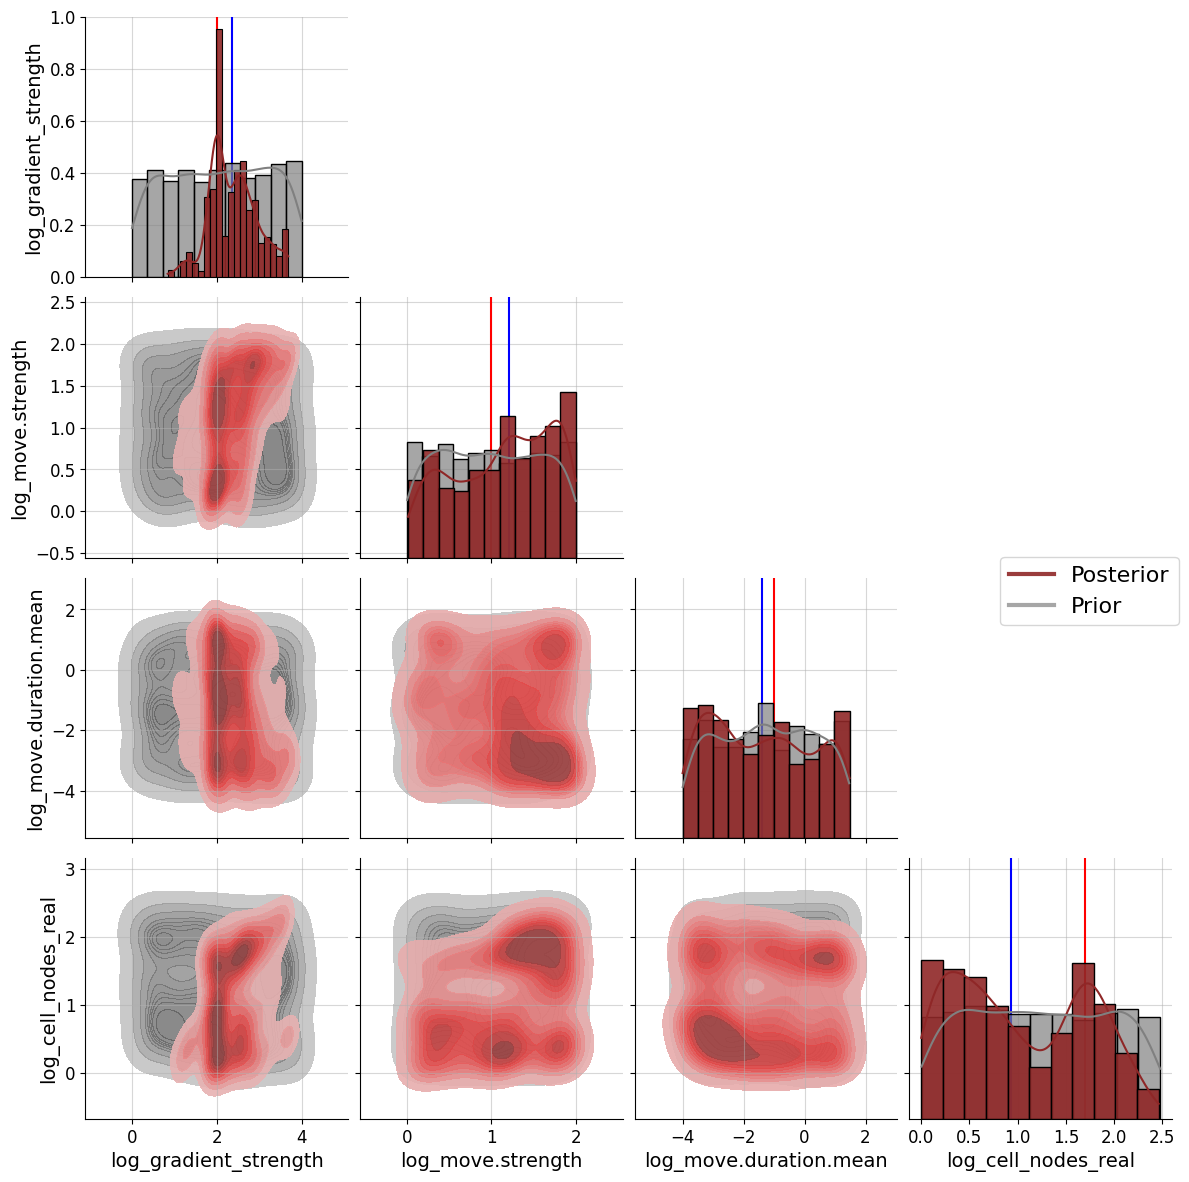

In [18]:
prior_draws = np.array([list(prior.rvs().values()) for _ in range(abc_posterior_samples.shape[0])])
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=abc_posterior_samples,
                                       prior_draws=prior_draws,
                                       param_names=log_param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(log_param_names) * (len(log_param_names)+1):
        a.axvline(test_params[i // len(log_param_names)], color='r', label='True parameter')
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(log_param_names) * (len(log_param_names)+1):
        a.axvline(abc_median[i // len(log_param_names)], color='b', label='Median parameter')
plt.savefig(os.path.join(gp, 'abc_results/posterior_vs_prior.png'))
plt.show()

In [29]:
# load bayesflow posterior samples
bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-attention-8-manual/posterior_samples_synthetic.npy')
bayesflow_median = np.median(bayesflow_posterior_samples, axis=0)

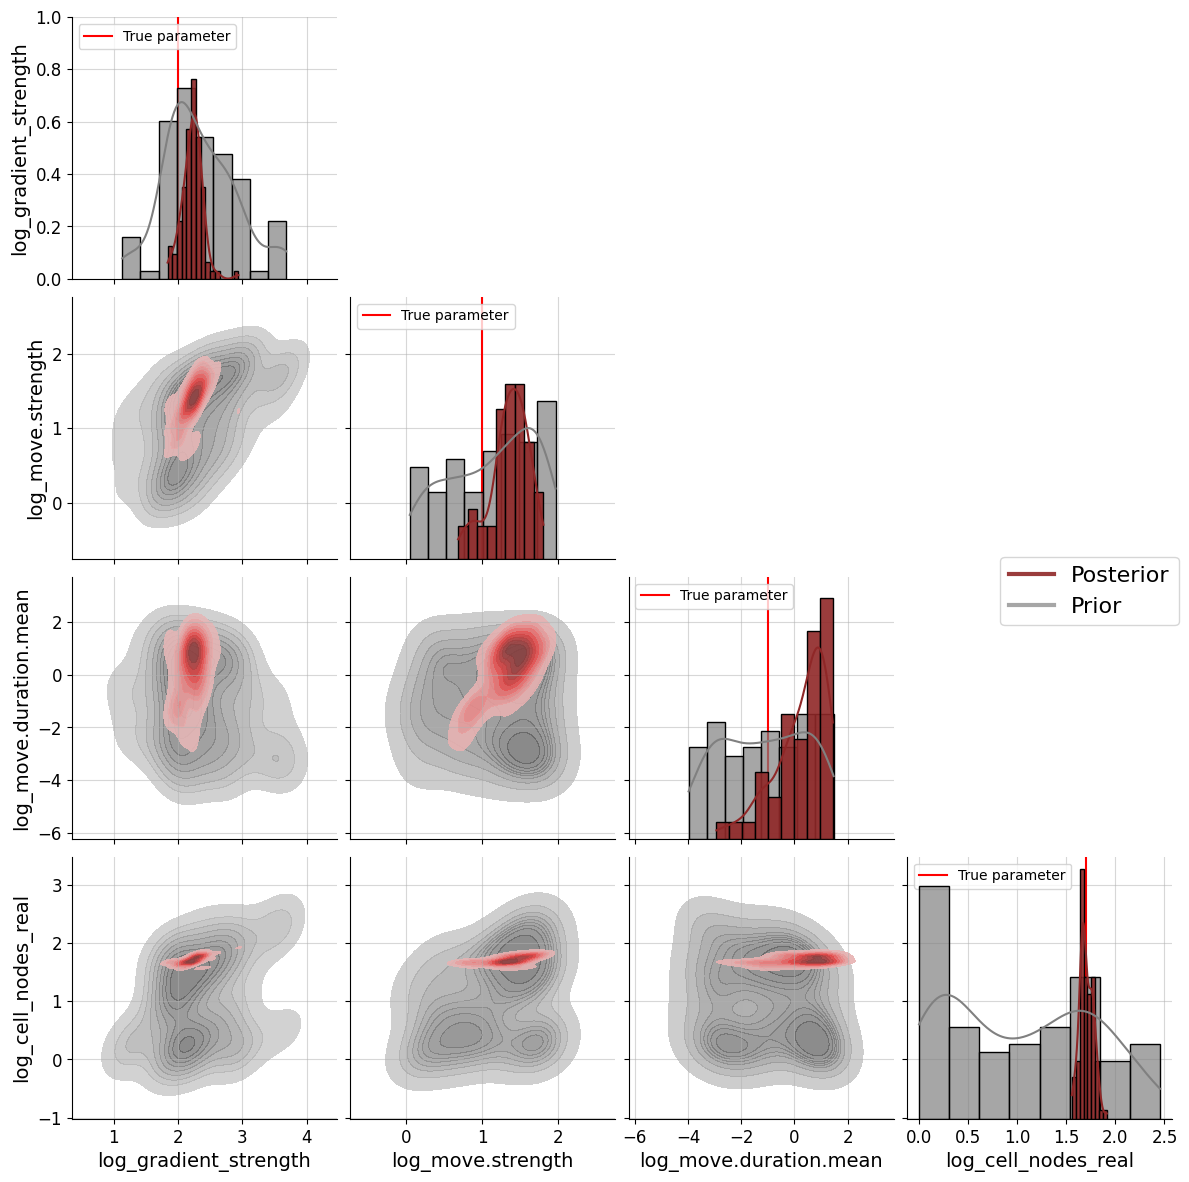

In [34]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=bayesflow_posterior_samples,
                                       prior_draws=abc_posterior_samples[:bayesflow_posterior_samples.shape[0]],
                                       param_names=log_param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(log_param_names) * (len(log_param_names)+1):
        a.axvline(test_params[i // len(log_param_names)], color='r', label='True parameter')
        a.legend(loc='upper left')
plt.savefig(os.path.join(gp, 'abc_results/posterior_abc_vs_posterior_bayesflow.png'))
plt.show()

In [17]:
# get posterior samples and simulate
if not os.path.exists(os.path.join(gp, 'abc_results/posterior_sim.npy')):
    # simulate the data
    sim_list = []
    for i in tqdm(range(10)):
        if i == 0:
            sim_dict = {key: p for key, p in zip(obs_pars.keys(), abc_median)}
        else:
            sim_dict = {key: p for key, p in zip(obs_pars.keys(), abc_posterior_samples[i])}
        posterior_sim = model(sim_dict)
        sim_list.append(posterior_sim['sim'])
    posterior_sim = np.concatenate(sim_list)
    np.save(os.path.join(gp, 'abc_results/posterior_sim.npy'), posterior_sim)
else:
    #posterior_sim = np.load(os.path.join(gp, 'abc_results/posterior_sim_prior.npy'))
    posterior_sim = np.load(os.path.join(gp, 'abc_results/posterior_sim.npy'))

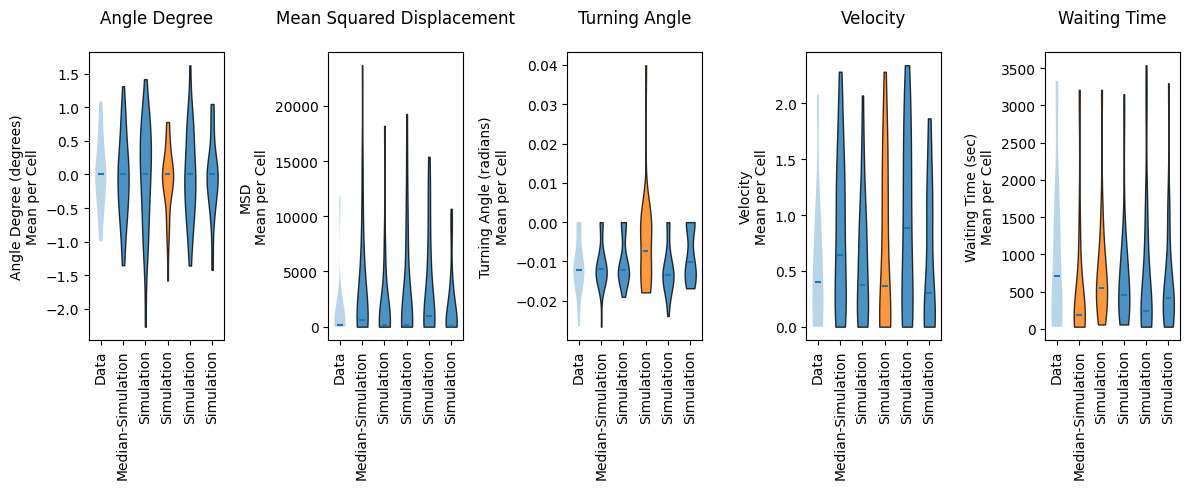

Wasserstein distance: 2463.5770229925593


In [13]:
# plot the summary statistics
plot_compare_summary_stats(test_sim, posterior_sim, path='abc_results/Summary Stats');

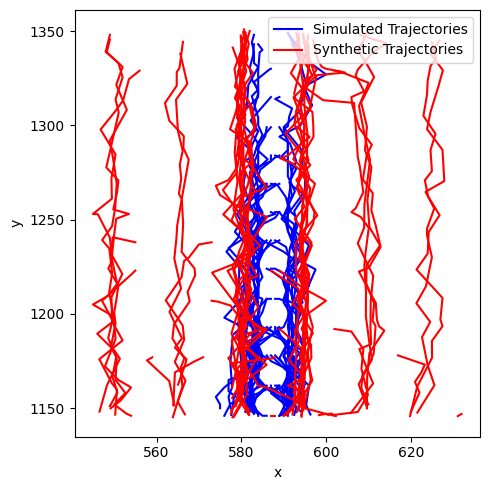

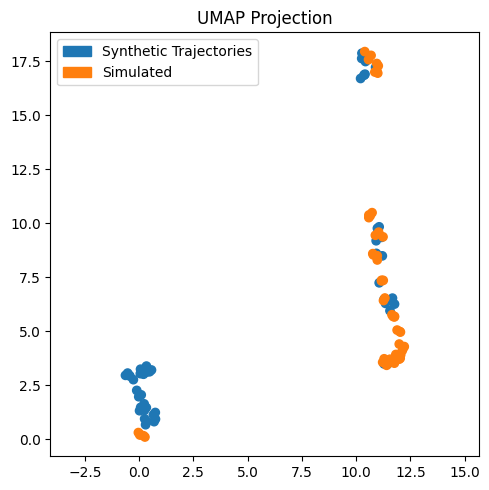

In [16]:
# plot the trajectory
plot_trajectory(test_sim[0], posterior_sim[0], path='abc_results/Simulations', show_umap=True)

In [ ]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        valid_data = pickle.load(f)
else:
    raise FileNotFoundError('Validation data not found')

x_mean = np.nanmean(valid_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(valid_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(valid_data['prior_draws'], axis=0)
p_std = np.std(valid_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)


# compute the mean of the summary statistics
summary_stats_list_ = [reduced_coordinates_to_sumstat(t) for t in valid_data['sim_data']]
(_, ad_averg, _, MSD_averg, _, TA_averg, _, VEL_averg, _, WT_averg) = compute_mean_summary_stats(summary_stats_list_, remove_nan=False)

direct_conditions_ = np.stack([ad_averg, MSD_averg, TA_averg, VEL_averg, WT_averg]).T
# replace inf with -1
direct_conditions_[np.isinf(direct_conditions_)] = np.nan
        
summary_valid_max = np.nanmax(direct_conditions_, axis=0)
summary_valid_min = np.nanmin(direct_conditions_, axis=0)

In [ ]:
def configurator(forward_dict: dict, manual_summary: bool = False) -> dict:
    out_dict = {}

    # Extract data
    x = forward_dict["sim_data"]
    
    # compute manual summary statistics
    if manual_summary:
        summary_stats_list = [reduced_coordinates_to_sumstat(t) for t in x]
        # compute the mean of the summary statistics
        (_, ad_averg, _, MSD_averg, _, 
         TA_averg, _, VEL_averg, _, WT_averg) = compute_mean_summary_stats(summary_stats_list, remove_nan=False)
        direct_conditions = np.stack([ad_averg, MSD_averg, TA_averg, VEL_averg, WT_averg]).T   
        # normalize statistics
        direct_conditions = (direct_conditions - summary_valid_min) / (summary_valid_max - summary_valid_min)
        # replace nan or inf with -1
        direct_conditions[np.isinf(direct_conditions)] = -1
        direct_conditions[np.isnan(direct_conditions)] = -1
        out_dict['direct_conditions'] = direct_conditions.astype(np.float32)
    
    # Normalize data
    x = (x - x_mean) / x_std
    
    # Check for NaN values in the first entry of the last axis
    # If nan_mask is False (no NaNs), set to 1; otherwise, set to 0
    nan_mask = np.isnan(x[..., 0])
    new_dim = np.where(nan_mask, 0, 1)
    new_dim_expanded = np.expand_dims(new_dim, axis=-1)
    x = np.concatenate((x, new_dim_expanded), axis=-1)

    # Normalize data
    x[np.isnan(x)] = 0  # replace nan with 0, pre-padding (since we have nans in the data at the end)
    out_dict['summary_conditions'] = x.astype(np.float32)

    # Extract params
    if 'parameters' in forward_dict.keys():
        forward_dict["prior_draws"] = forward_dict["parameters"]
    if 'prior_draws' in forward_dict.keys():
        params = forward_dict["prior_draws"]
        params = (params - p_mean) / p_std
        out_dict['parameters'] = params.astype(np.float32)
    return out_dict

In [ ]:
import logging

def load_model(model_id):
    # Set the logger to the desired level
    tf.get_logger().setLevel('ERROR')  # This will suppress warnings and info logs from TensorFlow

    # define the network
    # define the network
    class GroupSummaryNetwork(tf.keras.Model):
        """Network to summarize the data of groups of cells.  Each group is passed through a series of convolutional layers
        followed by an LSTM layer. The output of the LSTM layer is then pooled across the groups and dense layer applied
        to obtain a summary of fixed dimensionality. The network is invariant to the order of the groups.
        """

        def __init__(
                self,
                summary_dim,
                num_conv_layers=2,
                rnn_units=128,
                bidirectional=True,
                conv_settings=None,
                use_attention=False,
                return_attention_weights=False,
                use_GRU=True,
                **kwargs
        ):
            super().__init__(**kwargs)

            if conv_settings is None:
                conv_settings = defaults.DEFAULT_SETTING_MULTI_CONV
            self.conv_settings = conv_settings

            conv = Sequential([MultiConv1D(conv_settings) for _ in range(num_conv_layers)])
            self.num_conv_layers = num_conv_layers
            self.group_conv = tf.keras.layers.TimeDistributed(conv)
            self.use_attention = use_attention
            self.return_attention_weights = return_attention_weights
            self.pooling = tf.keras.layers.GlobalAveragePooling1D()
            self.rnn_units = rnn_units
            self.use_GRU = use_GRU
            self.bidirectional = bidirectional

            if self.use_attention:
                self.attention = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=rnn_units)

            if use_GRU:
                rnn = Bidirectional(GRU(rnn_units, return_sequences=use_attention)) if bidirectional else GRU(rnn_units,
                                                                                                              return_sequences=use_attention)
            else:
                rnn = Bidirectional(LSTM(rnn_units, return_sequences=use_attention)) if bidirectional else LSTM(
                    rnn_units, return_sequences=use_attention)
            self.group_rnn = tf.keras.layers.TimeDistributed(rnn)

            self.out_layer = Dense(summary_dim, activation="linear")
            self.summary_dim = summary_dim

        def call(self, x, **kwargs):
            """Performs a forward pass through the network by first passing `x` through the same rnn network for
            each household and then pooling the outputs across households.

            Parameters
            ----------
            x : tf.Tensor
                Input of shape (batch_size, n_groups, n_time_steps, n_features)

            Returns
            -------
            out : tf.Tensor
                Output of shape (batch_size, summary_dim)
            """
            # Apply the RNN to each group
            out = self.group_conv(x, **kwargs)
            out = self.group_rnn(out, **kwargs)  # (batch_size, n_groups, lstm_units)
            # if attention is used, return full sequence (batch_size, n_groups, n_time_steps, lstm_units)
            # bidirectional LSTM returns 2*lstm_units

            if self.use_attention:
                # learn a query vector to attend over the time points
                query = tf.reduce_mean(out, axis=1)
                # Reshape query to match the required shape for attention
                query = tf.expand_dims(query, axis=1)  # (batch_size, 1, n_time_steps, lstm_units)
                if not self.return_attention_weights:
                    out = self.attention(query, out, **kwargs)  # (batch_size, 1, n_time_steps, lstm_units)
                else:
                    out, attention_weights = self.attention(query, out, return_attention_scores=True, **kwargs)
                    attention_weights = tf.squeeze(attention_weights, axis=2)
                out = tf.squeeze(out, axis=1)  # Remove the extra dimension (batch_size, n_time_steps, lstm_units)
                out = self.pooling(out, **kwargs)  # (batch_size, 1, lstm_units)
            else:
                # pooling over groups, this totally invariants to the order of the groups
                out = self.pooling(out, **kwargs)  # (batch_size, lstm_units)
            # apply dense layer
            out = self.out_layer(out, **kwargs)  # (batch_size, summary_dim)

            if self.use_attention and self.return_attention_weights:
                return out, attention_weights
            return out

        def get_config(self):
            """Return the config for serialization."""
            config = super().get_config()
            config.update({
                'summary_dim': self.summary_dim,
                'num_conv_layers': self.num_conv_layers,
                'rnn_units': self.rnn_units,
                'bidirectional': self.bidirectional,
                'conv_settings': self.conv_settings,
                'use_attention': self.use_attention,
                'return_attention_weights': self.return_attention_weights,
                'use_GRU': self.use_GRU,
            })
            return config

        @classmethod
        def from_config(cls, config):
            """Recreate the model from the config."""
            return cls(**config)

    num_coupling_layers = 6
    num_dense = 3
    use_attention = True
    use_bidirectional = True
    summary_loss = 'MMD'
    use_manual_summary = False
    if model_id == 0:
        checkpoint_path = 'amortizer-cell-migration-attention-6'
    elif model_id == 1:
        checkpoint_path = 'amortizer-cell-migration-attention-6-manual'
        use_manual_summary = True
    elif model_id == 2:
        checkpoint_path = 'amortizer-cell-migration-attention-7'
        num_coupling_layers = 7
    elif model_id == 3:
        checkpoint_path = 'amortizer-cell-migration-attention-7-manual'
        num_coupling_layers = 7
        use_manual_summary = True
    elif model_id == 4:
        checkpoint_path = 'amortizer-cell-migration-attention-8'
        num_coupling_layers = 8
    elif model_id == 5:
        checkpoint_path = 'amortizer-cell-migration-attention-8-manual'
        num_coupling_layers = 8
        use_manual_summary = True
    else:
        raise ValueError('Checkpoint path not found')
    os.makedirs(f"../results/{checkpoint_path}", exist_ok=True)

    summary_net = GroupSummaryNetwork(summary_dim=len(obs_pars) * 2,
                                      rnn_units=32,
                                      use_attention=use_attention,
                                      bidirectional=use_bidirectional)
    inference_net = InvertibleNetwork(num_params=len(obs_pars),
                                      num_coupling_layers=num_coupling_layers,
                                      coupling_design='spline',
                                      coupling_settings={
                                          "num_dense": num_dense,
                                          "dense_args": dict(
                                              activation='relu',
                                              kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                                          ),
                                          "dropout_prob": 0.2,
                                          "bins": 16,
                                      })

    amortizer = AmortizedPosterior(inference_net=inference_net, summary_net=summary_net,
                                   summary_loss_fun=summary_loss)

    # Disable logging
    logging.disable(logging.CRITICAL)

    # build the trainer with networks
    max_to_keep = 17
    trainer = Trainer(amortizer=amortizer,
                      configurator=partial(configurator,
                                           manual_summary=use_manual_summary),
                      checkpoint_path=checkpoint_path,
                      skip_checks=True,
                      max_to_keep=max_to_keep)

    # check if file exist
    if os.path.exists(checkpoint_path):
        trainer.load_pretrained_network()
        history = trainer.loss_history.get_plottable()
    else:
        raise FileNotFoundError('Checkpoint path not found')

    # Find the checkpoint with the lowest validation loss out of the last max_to_keep
    recent_losses = history['val_losses'].iloc[-max_to_keep:]
    best_valid_epoch = recent_losses['Loss'].idxmin() + 1  # checkpoints are 1-based indexed
    new_checkpoint = trainer.manager.latest_checkpoint.rsplit('-', 1)[0] + f'-{best_valid_epoch}'
    trainer.checkpoint.restore(new_checkpoint)
    #print("Networks loaded from {}".format(new_checkpoint))

    # Re-enable logging
    logging.disable(logging.NOTSET)

    return summary_net, use_manual_summary

In [ ]:
_ = load_model(5)

In [ ]:
# use trained neural net as summary statistics
def make_sumstat_dict_nn(
        data: Union[dict, np.ndarray],
        config_map: callable,
) -> dict:
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]

    summary_nn, manual_summary = load_model(5)

    # configures the input for the network
    config_input = config_map({"sim_data": data}, manual_summary=manual_summary)
    # get the summary statistics
    out_dict = {
        'summary_net': summary_nn(config_input['summary_conditions']).numpy().flatten()
    }
    # if direct conditions are available, concatenate them
    if 'direct_conditions' in config_input.keys():
        out_dict['direct_conditions'] = config_input['direct_conditions'].flatten()
    return out_dict


sumstats_nn = partial(make_sumstat_dict_nn,
                      config_map=configurator)

if on_cluster:
    # define the model object
    model_nn = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model_nn = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

In [ ]:
%%time
synthetic_data_test_nn = sumstats_nn(test_sim)
synthetic_data_test_nn

In [ ]:
#redis_sampler = RedisEvalParallelSampler(host=args.ip, port=args.port,
#                                         adapt_look_ahead_proposal=False,
#                                         look_ahead=False)

abc_nn = pyabc.ABCSMC(model_nn, prior, # here we use now the Euclidean distance
                      population_size=population_size,
                      summary_statistics=sumstats_nn,
                      sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                      #sampler=redis_sampler
                      )

db_path = os.path.join(gp, "abc_results/synthetic_test_nn_sumstats.db")

if not os.path.exists(db_path):
    history_nn = abc_nn.new("sqlite:///" + db_path, make_sumstat_dict(test_sim))

    # start the abc fitting
    abc_nn.run(min_acceptance_rate=1e-2, max_nr_populations=30)
    print('Done!')
else:
    history_nn = abc_nn.load("sqlite:///" + db_path)

In [ ]:
fig, ax = plt.subplots(1, len(param_names), tight_layout=True, figsize=(12, 4))
for i, param in enumerate(param_names):
    for t in range(history_nn.max_t + 1):
        df, w = history_nn.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=limits_log[param][0],
            xmax=limits_log[param][1],
            x=param,
            xname=log_param_names[i],
            ax=ax[i],
            label=f"PDF t={t}",
        )
    ax[i].legend()
    ax[i].set_xlim((limits_log[param][0]-0.2, limits_log[param][1]+0.2))
plt.savefig(os.path.join(gp, 'abc_results/population_kdes_nn.png'))
plt.show()

fig, arr_ax = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)
arr_ax = arr_ax.flatten()
pyabc.visualization.plot_sample_numbers(history_nn, ax=arr_ax[0])
pyabc.visualization.plot_walltime(history_nn, ax=arr_ax[1], unit='h')
pyabc.visualization.plot_epsilons(history_nn, ax=arr_ax[2])
pyabc.visualization.plot_effective_sample_sizes(history_nn, ax=arr_ax[3])
pyabc.visualization.plot_acceptance_rates_trajectory(history_nn, ax=arr_ax[4])
# remove last axis
arr_ax[-1].axis('off')
plt.savefig(os.path.join(gp, 'abc_results/diagnostics_nn.png'))
plt.show()

pyabc.visualization.plot_credible_intervals(history_nn, levels=[0.95]);

In [ ]:
abc_df, abc_w = history_nn.get_distribution()
abc_posterior_samples_nn = resample(abc_df[param_names].values, abc_w, n=1000)
abc_nn_median = np.median(abc_posterior_samples_nn, axis=0)

In [ ]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=abc_posterior_samples_nn,
                                       prior_draws=prior_draws,
                                       param_names=log_param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(log_param_names) * (len(log_param_names)+1):
        a.axvline(test_params[i // len(log_param_names)], color='b', label='True parameter')
plt.savefig(os.path.join(gp, 'abc_results/posterior_vs_prior_nn_summary.png'))
plt.show()

In [ ]:
# get posterior samples and simulate
if not os.path.exists(os.path.join(gp, 'abc_results/posterior_sim_nn.npy')):
    # simulate the data
    sim_list = []
    for i in tqdm(range(10)):
        if i == 0:
            sim_dict = {key: p for key, p in zip(obs_pars.keys(), abc_nn_median)}
        else:
            sim_dict = {key: p for key, p in zip(obs_pars.keys(), abc_posterior_samples_nn[i])}
        posterior_sim = model_nn(sim_dict)
        sim_list.append(posterior_sim['sim'])
    posterior_sim_nn = np.concatenate(sim_list)
    np.save(os.path.join(gp, 'abc_results/posterior_sim_nn.npy'), posterior_sim_nn)
else:
    posterior_sim_nn = np.load(os.path.join(gp, 'abc_results/posterior_sim_nn.npy'))

In [ ]:
# plot the summary statistics
plot_compare_summary_stats(test_sim, posterior_sim_nn, path='abc_results/Summary Stats NN.png');

In [ ]:
# plot the trajectory
plot_trajectory(test_sim[0], posterior_sim_nn[0], path='abc_results/Simulations NN.png')